# Data Madness

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import pandasql as ps
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re
from sklearn.model_selection import train_test_split
from subprocess import check_output
import pydot
from sklearn.metrics import accuracy_score
import math

In [2]:
# process the data
def get_data(filename):
    data = pd.read_csv(filename)
    data = data.rename(index=str, columns={"location x": "location_y", "location y": "location_x"})
    #data[data['loc_x'].isnull()]
    data = data.dropna(subset=['location_x','location_y'])
    # standardize x-axis to range (-250,250) from the range (0,500) for easier translation
    data['location_x'] = data['location_x'] - 250
    # because a court has two sides and we only want to visualize on one side, we have to flip shots from the other side to the proper side of other
    court_midpoint = 940 / 2
    data.loc[data['location_y'] > court_midpoint, "location_x"] *= -1
    data.loc[data['location_y'] > court_midpoint, "location_y"] -= 940
    data.loc[data['location_y'] < 0, "location_y"] *= -1
    data['location_y'] = data['location_y'] - 60

    data['current shot outcome'] = (data['current shot outcome'] == 'SCORED')
    data['current shot outcome'] = data['current shot outcome'].astype(int)
    return data

## Question 1 - visualization of shots

- Thanks to Savvas Tjortjoglou for the inspiration on drawing the basketball court elements using matplotlib found on his blog post http://savvastjortjoglou.com/nba-shot-sharts.html 
- Thanks to Jake VanderPlas for the inspiration on drawing Gaussian Mixture model as elipsis based on the mean and variance in 2D space using matplotlib as found on his blog post https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html and the book Python Data Science Handbook (https://jakevdp.github.io/PythonDataScienceHandbook/)

In [3]:
#%% the draw function from Savvas Tjortjoglou

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    #hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [ backboard, outer_box, inner_box, top_free_throw, # hoop,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
## our function to draw the gaussian mixture model with elipses
def draw_2D_gmm(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5 * np.sqrt(v)  # go to units of standard deviation instead of variance

        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)

        h.text(mean[0] + 7, mean[1] - 1, ellipseTextMessages[i], fontsize=15, color='blue')



Text(0.5,1,'shot accuracy')

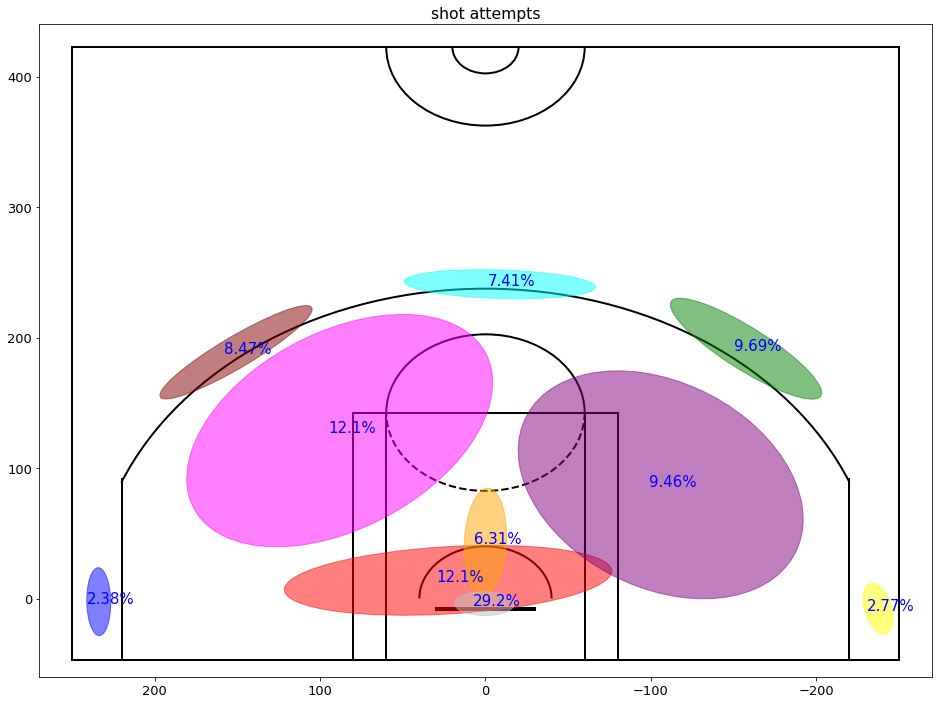

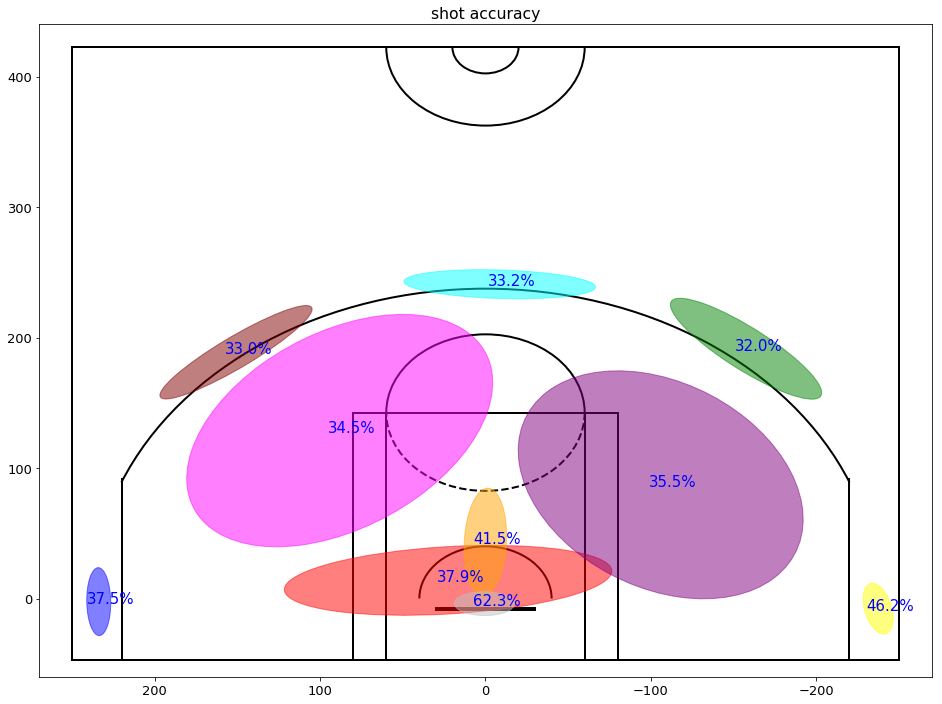

In [28]:

# 1. load the data

filename = "/Volumes/SD/Downloads/NBA_shot_log_16-17_regular_season/shot log PHI.csv"
data = get_data(filename)

# 2. train the Gaussian mixture model
num_clusters = 10
gmmodel = mixture.GaussianMixture(n_components=num_clusters, verbose=0, random_state=5,
                                  n_init=50, covariance_type='full', init_params='kmeans')
gmmodel.fit(data.loc[:, ['location_x', 'location_y']])

# 3. add the according GMM cluster as a field into the dataset
data['shotLocationCluster'] = gmmodel.predict(data.loc[:, ['location_x', 'location_y']])

# 4. plot the distribution of shot attempts per cluster

# 4.a) get the GMM weights for a cluster as well as prepare colors
cluster_weights = [str(100 * gmmodel.weights_[x])[:4] + '%' for x in range(num_clusters)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
# 4.b) do the plotting
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 13
# draw the 2D gaussian elipsis based on mean, variance
draw_2D_gmm(gmmodel, ellipseColors, cluster_weights)
draw_court(outer_lines=True);
plt.ylim(-60,440);
plt.xlim(270,-270); # court size limits
plt.title('shot attempts')

# accuracy

# 5. plot the accuracy of shot attempts at each cluster
# 5.a) for each cluster, calculate it's individual accuracy
cluster_accuracy = {}
shots_per_cluster = data['shotLocationCluster'].value_counts().index.tolist()

for cluster in shots_per_cluster:
    total_shot_attempts = np.array(data['shotLocationCluster'] == cluster).sum()
    total_shots_made = np.array(data.loc[data['shotLocationCluster'] == cluster, 'current shot outcome'] == 1).sum()
    cluster_accuracy[cluster] = float(total_shots_made) / total_shot_attempts

cluster_accuracies = [str(100 * cluster_accuracy[x])[:4] + '%' for x in range(num_clusters)]

# 5.b) plot the accuracies
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 13
# draw the 2D gaussian elipsis based on mean, variance
draw_2D_gmm(gmmodel, ellipseColors, cluster_accuracies)
draw_court(outer_lines=True);
plt.ylim(-60,440);
plt.xlim(270,-270);
plt.title('shot accuracy')

## Question 2 - hot hand fallacy

In [6]:
from os import walk

mypath = "/Volumes/SD/Downloads/NBA_shot_log_16-17_regular_season"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

filename = "/Volumes/SD/Downloads/NBA_shot_log_16-17_regular_season/shot log GSW.csv"
data = get_data(filename)

for filename in f:
    # ignore these hidden files
    if(filename.startswith('.')):
        pass
    else:
        print(filename)
        data = data.append(get_data(mypath + "/" + filename), ignore_index=True)


shot log ATL.csv
shot log BOS.csv
shot log BRO.csv
shot log CHA.csv
shot log CHI.csv
shot log CLE.csv
shot log DAL.csv
shot log DEN.csv
shot log DET.csv
shot log GSW.csv
shot log HOU.csv
shot log IND.csv
shot log LAC.csv
shot log LAL.csv
shot log MEM.csv
shot log MIA.csv
shot log MIL.csv
shot log MIN.csv
shot log NOP.csv
shot log NYK.csv
shot log OKL.csv
shot log ORL.csv
shot log PHI.csv
shot log PHX.csv
shot log POR.csv
shot log SAC.csv
shot log SAS.csv
shot log TOR.csv
shot log UTA.csv
shot log WAS.csv


In [7]:
def func(x):
    '''
    if(x['current shot outcome'] == 1):
        x['streak'] = x.shift(1)['streak'] + 1
    else:
        x['streak'] = 0
    '''
    x['streak1'] = x.shift(1)['current shot outcome']
    x['streak2'] = x.shift(2)['current shot outcome']
    x['streak3'] = x.shift(3)['current shot outcome']
    x['streak4'] = x.shift(4)['current shot outcome']
    x['streak5'] = x.shift(5)['current shot outcome']
    x['streak6'] = x.shift(6)['current shot outcome']
    x['streak7'] = x.shift(7)['current shot outcome']
    x['streak8'] = x.shift(8)['current shot outcome']
    x['streak9'] = x.shift(9)['current shot outcome']
    x['streak10'] = x.shift(10)['current shot outcome']
    x['streak11'] = x.shift(11)['current shot outcome']
    x['streak12'] = x.shift(12)['current shot outcome']
    x['streak13'] = x.shift(13)['current shot outcome']
    x['streak14'] = x.shift(14)['current shot outcome']
    x['streak15'] = x.shift(15)['current shot outcome']
    
    return x
    print(x)
    
data2 = data.groupby(['shoot player']).apply(func).fillna(0)
data2["streak"] = data2["streak1"].map(str) + ","+ data2["streak2"].map(str) + ","+ data2["streak3"].map(str) + ","+ \
    data2["streak4"].map(str) + ","+ data2["streak5"].map(str) + ","+ data2["streak6"].map(str) + ","+\
    data2["streak7"].map(str) + ","+ data2["streak8"].map(str) + ","+ data2["streak9"].map(str) + ","+\
    data2["streak10"].map(str) + ","+ data2["streak11"].map(str) + ","+ data2["streak12"].map(str) + ","+\
    data2["streak13"].map(str) + ","+ data2["streak14"].map(str) + ","+ data2["streak15"].map(str)

data2 = data2.drop(axis = 1, labels = ['streak1','streak2','streak3','streak4','streak5','streak6','streak7','streak8','streak9','streak10','streak11','streak12','streak13','streak14','streak15'])

In [8]:
data2

,self previous shot,player position,home game,location_y,opponent previous shot,home team,shot type,points,away team,location_x,time,date,shoot player,time from last shot,quarter,current shot outcome,streak
0,0,PF,Yes,184.0,MISSED,GSW,Jump Shot,3,SAS,-158.0,0:39,2016-10-25,Draymond Green,0.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
1,MISSED,SF,Yes,137.0,SCORED,GSW,Turnaround Fadeaway,2,SAS,-6.0,1:05,2016-10-25,Kevin Durant,26.0,1,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,SCORED,SG,Yes,14.0,SCORED,GSW,Running Reverse Layup,2,SAS,1.0,1:40,2016-10-25,Klay Thompson,35.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,MISSED,PF,Yes,-6.0,MISSED,GSW,Cutting Layup Shot,2,SAS,-19.0,2:32,2016-10-25,Draymond Green,52.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4,MISSED,PG,Yes,248.0,MISSED,GSW,Jump Shot,3,SAS,130.0,2:58,2016-10-25,Stephen Curry,26.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
5,MISSED,PG,Yes,165.0,SCORED,GSW,Step Back Jump Shot,3,SAS,189.0,3:54,2016-10-25,Stephen Curry,56.0,1,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
6,SCORED,SG,Yes,243.0,MISSED,GSW,Pullup Jump Shot,3,SAS,-19.0,4:34,2016-10-25,Klay Thompson,40.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
7,MISSED,SF,Yes,38.0,MISSED,GSW,Step Back Jump Shot,2,SAS,-163.0,5:01,2016-10-25,Kevin Durant,27.0,1,1,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
8,SCORED,SF,Yes,32.0,MISSED,GSW,Turnaround Fadeaway,2,SAS,163.0,5:34,2016-10-25,Kevin Durant,33.0,1,1,"1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
9,SCORED,SF,Yes,184.0,MISSED,GSW,Pullup Jump Shot,3,SAS,173.0,5:59,2016-10-25,Kevin Durant,25.0,1,1,"1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."


In [9]:
def length_streak(x):
    x = x.split(',')
    
    cnt = 0
    
    last_shot = float(x[0])
    del x[0]
    
    for i in reversed(x):
        if float(i) == last_shot:
            cnt+=1
        else:
            if(last_shot == 0.0):
                cnt *= -1
            return cnt
    cnt *= -1
    return cnt
    
data2['streak_length'] = data2['streak'].map(length_streak)
data2['distance'] = (data2['location_x'] ** 2 + data2['location_y']**2)**0.5

data2['distance'] = data2['distance']/data2['distance'].mean()

data2.head()

,self previous shot,player position,home game,location_y,opponent previous shot,home team,shot type,points,away team,location_x,time,date,shoot player,time from last shot,quarter,current shot outcome,streak,streak_length,distance
0,0,PF,Yes,184.0,MISSED,GSW,Jump Shot,3,SAS,-158.0,0:39,2016-10-25,Draymond Green,0.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",-14,1.882976
1,MISSED,SF,Yes,137.0,SCORED,GSW,Turnaround Fadeaway,2,SAS,-6.0,1:05,2016-10-25,Kevin Durant,26.0,1,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",-14,1.064680
2,SCORED,SG,Yes,14.0,SCORED,GSW,Running Reverse Layup,2,SAS,1.0,1:40,2016-10-25,Klay Thompson,35.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",-14,0.108972
3,MISSED,PF,Yes,-6.0,MISSED,GSW,Cutting Layup Shot,2,SAS,-19.0,2:32,2016-10-25,Draymond Green,52.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",-14,0.154695
4,MISSED,PG,Yes,248.0,MISSED,GSW,Jump Shot,3,SAS,130.0,2:58,2016-10-25,Stephen Curry,26.0,1,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",-14,2.173959


In [10]:
plot_data = data2.groupby(['streak_length'])[['current shot outcome']].mean()
plot_data = plot_data.rename(index=str, columns={"streak_length": "Consecutive shots made", "current shot outcome": "Probability of making the next shot"})
plot_data['Consecutive shots made'] = plot_data.index
plot_data['Consecutive shots made'] = plot_data['Consecutive shots made'].astype(int)

plot_data_pos = plot_data[plot_data['Consecutive shots made'] >= 0]
plot_data_neg = plot_data[plot_data['Consecutive shots made'] < 0]

Text(0,0.5,'Probability of making the next shot')

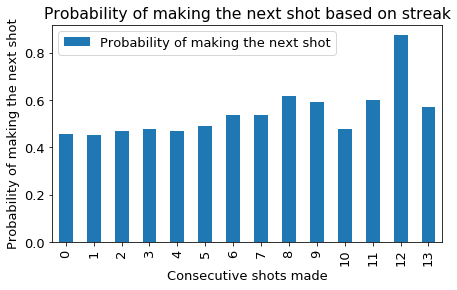

In [11]:
ax = plot_data_pos.drop(axis=1,labels='Consecutive shots made').plot(stacked=True, kind = 'bar', title='Probability of making the next shot based on streak', legend = True, figsize = (7,4))
ax.set_xlabel("Consecutive shots made")
ax.set_ylabel("Probability of making the next shot")

Text(0,0.5,'Probability of making the next shot')

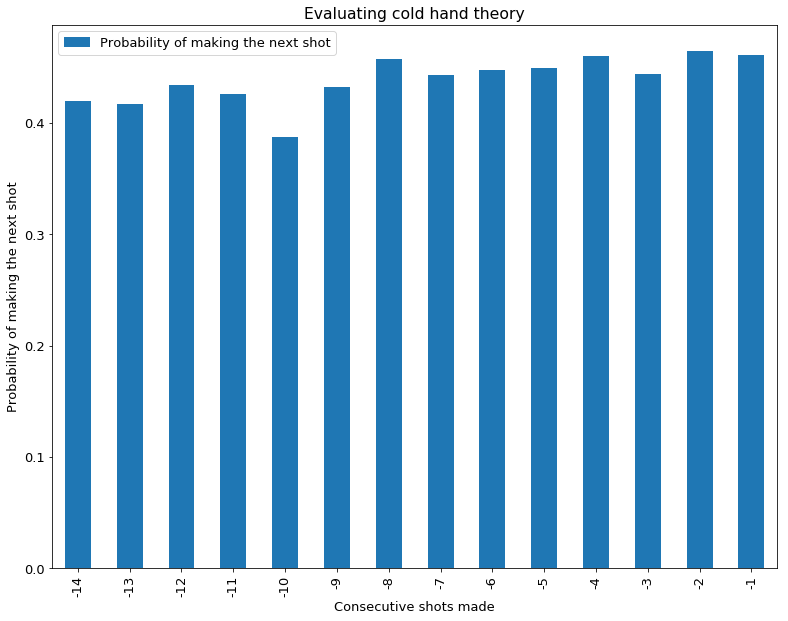

In [12]:
ax = plot_data_neg.drop(axis=1,labels='Consecutive shots made').plot(stacked=True, kind = 'bar', title='Evaluating cold hand theory', legend = True, figsize = (13,10))
ax.set_xlabel("Consecutive shots made")
ax.set_ylabel("Probability of making the next shot")

Text(0,0.5,'Probability of making the next shot')

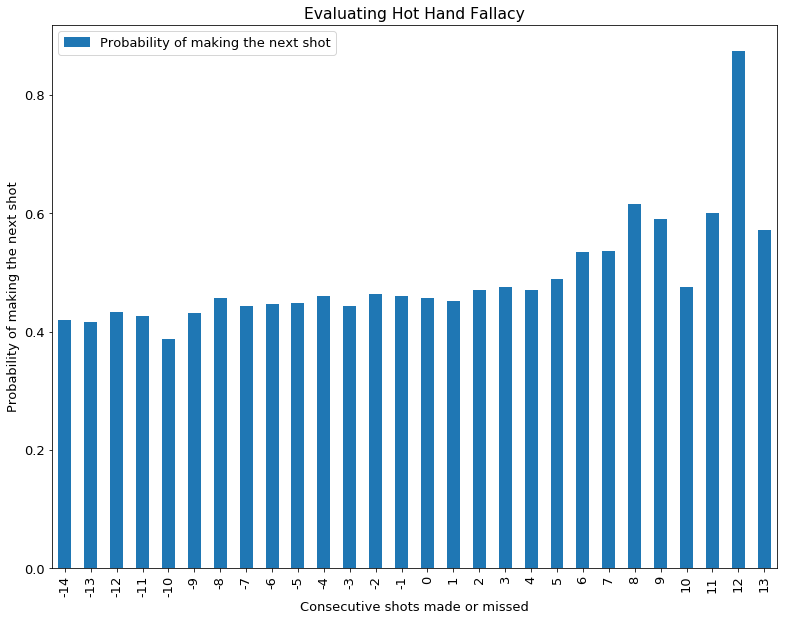

In [13]:
ax = plot_data.drop(axis=1,labels='Consecutive shots made').plot(stacked=True, kind = 'bar', title='Evaluating Hot Hand Fallacy', legend = True, figsize = (13,10))
ax.set_xlabel("Consecutive shots made or missed")
ax.set_ylabel("Probability of making the next shot")

Text(0,0.5,'Relative distance of next shot')

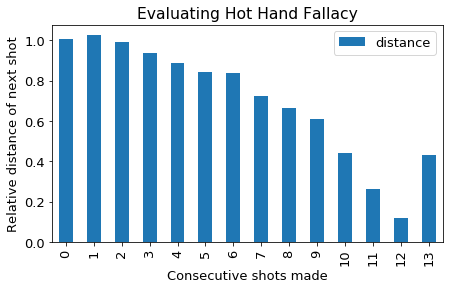

In [30]:
plot_data_dist = data2[data2['streak_length']>=0].groupby(['streak_length'])[['distance']].mean()
plot_data_dist = plot_data_dist.rename(index=str, columns={"streak_length": "Consecutive shots made", "current shot outcome": "Probability of making the next shot"})
plot_data_dist['Consecutive shots made'] = plot_data_dist.index
plot_data_dist['Consecutive shots made'] = plot_data_dist['Consecutive shots made'].astype(int) - 1
ax = plot_data_dist.drop(axis=1,labels='Consecutive shots made').plot(stacked=True, kind = 'bar', title='Evaluating Hot Hand Fallacy', legend = True, figsize = (7,4))
ax.set_xlabel("Consecutive shots made")
ax.set_ylabel("Relative distance of next shot")

Text(0.5,1,'Distribution of streaks')

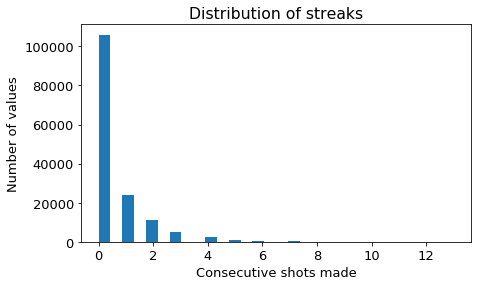

In [29]:
ax = pd.DataFrame.hist(data2[data2['streak_length'] >= 0], column = ['streak_length'], bins = 30, grid=False,figsize=(7,4))
#plt = data.plot(kind='hist',column = ['streak_length'], bins = 30, grid=False, subplots=True,sharex=True,sharey=True,title='My title')
ax[0][0].set_xlabel("Consecutive shots made")
ax[0][0].set_ylabel("Number of values")
ax[0][0].set_title("Distribution of streaks")



#ax.set_xlabel("Consecutive shots made or missed")
#ax.set_ylabel("Distance of the next shot compared to distance of average shot")

## Question 3 - Important features of a shot

In [16]:
filename = "/Volumes/SD/Downloads/NBA_shot_log_16-17_regular_season/shot log GSW.csv"
data = get_data(filename)
data_train = data[data['shoot player'] == 'Kevin Durant']



In [17]:
data_train = data_train.drop(axis=1, labels=['player position','shoot player','date','time','home team','away team','points',])
categorical_features = data_train.columns[data_train.dtypes == 'object']
print(categorical_features)
data_train2 = pd.get_dummies(data=data_train, columns=categorical_features)
data_train2 = data_train2.dropna()

Index(['self previous shot', 'home game', 'opponent previous shot',
       'shot type'],
      dtype='object')


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
     data_train2.drop(['current shot outcome'], axis = 1), data_train2['current shot outcome'], test_size=0.15, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

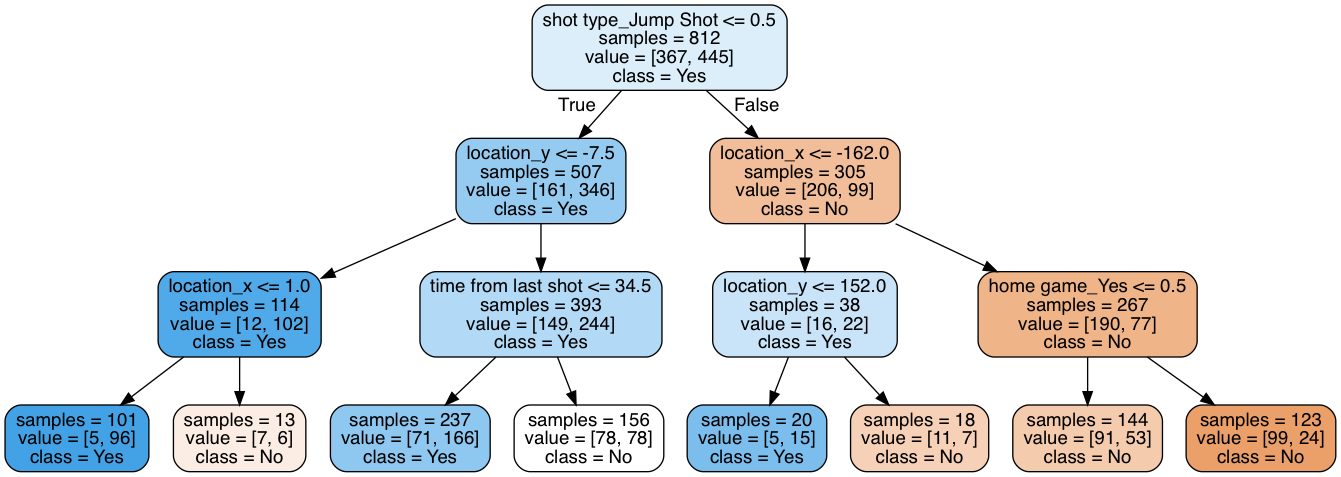

In [19]:
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree, out_file=f,
                              max_depth = 3, impurity = False,
                              feature_names = X_test.columns.values, class_names = ['No', 'Yes'],
                              rounded = True, filled= True )
        
#Convert .dot to .png to allow display in web notebook
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png")

Text(0.5,1,'Feature Importance')

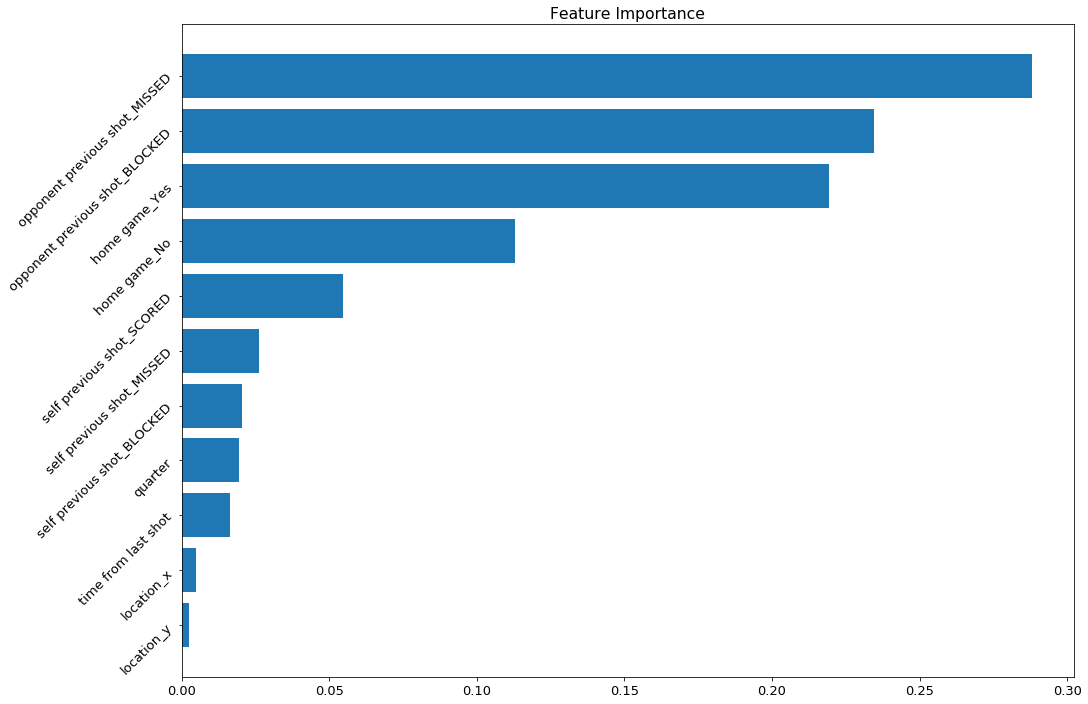

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     data_train2.drop(['current shot outcome'], axis = 1), data_train2['current shot outcome'], test_size=0.15, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 10)
decision_tree.fit(X_train, y_train)


ix = decision_tree.feature_importances_ > 0

ax = plt.barh(range(len(data_train2.drop(['current shot outcome'], axis = 1).columns.values[ix])), sorted(decision_tree.feature_importances_[ix]))
plt.yticks(range(len(data_train2.drop(['current shot outcome'], axis = 1).columns.values[ix])),data_train2.drop(['current shot outcome'], axis = 1).columns.values, rotation= 45)

plt.title('Feature Importance')

In [21]:
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.6527777777777778